# Functions

## Import Functions 

In [1]:
# Use to embed images in Jupyter Notebook
from IPython.display import Image

# Importing necesary modules
import sys
import os
import glob 
from os import listdir
from os import path

# Working with arrays 
import numpy as np

# Working with fits files and WCS objects 
import astropy.units as u
from astropy.time import Time 

# plotting and drawing modules 
from matplotlib import pyplot as plt
import matplotlib as mpl

#additional libraries needed for AFINO
import scipy.optimize as opt 
import scipy.signal as sig

# import reader for IDL files 
from scipy.io import readsav as idlsave

# import stats library 
import scipy.stats as stats 

## Defined Functions

In [2]:
# Define Reconnection Flux Rate  
def recrate(flx,h):
    '''Compute the difference formula for f'(a) with step size h.

    Parameters
    ----------
    flx : array containing reconection flux 
    h: contant cadance beyween observations 
    Returns
    -------
    recrate: reconection flux(a+h) - reconection flux(a-h))/2h
        [negative reconnection rate, positive reconnection rate] 
    '''    
    
    recrate    = np.zeros((2,len(flx[1,:])))
    
    nflux = flx[0] 
    pflux = flx[2]
    recrate[0] = np.gradient(nflux,h,edge_order =2)
    recrate[1] = np.gradient(pflux,h,edge_order =2)
    
    return recrate

In [3]:
# Check if .sav file exists 
def check(filename,bstr,wvstr):
    '''
    Written by Marcel 
    Oct. 21, 2020
    
    inputs: 
            filename -- name of the reconnection flux idl save file
            bstr     -- 
                        BLOS - normal component taken as the line of sight
                        BRAD - normal component taken as the radial magnatic field (B_r)
            wvstr    -- 
    output: 
            savname  -- full filename with extension of the reconnection flux
    '''
    for i in range(len(bstr)): 
        if path.exists(filename+bstr[i]+wvstr+".sav" ) == True:
            return  filename+bstr[i]+wvstr+".sav"
        else: 
            print('File not found! This file does not exist.')

In [4]:
def extract_ribbon_vars(idlstrct):
    '''
    Written by Marcel
    Oct. 5, 2020
    Inputs  --
    Outputs --  OPTIONAL (*) 
                *dosday --?
                flx6 -- magnetic reconnection flux for pixel area with I >= median(I)*6
                flx8 -- magnetic reconnection flux for pixel area with I >= median(I)*8
                flx10 -- magnetic reconnection flux for pixel area with I >= median(I)*10
                * area6 --?
                * area8 --? 
                * area10 --?
                * ar_area --? 
                * mflx --?
                tim -- UTC time from HMI 
                * cut --? 
                * sathr --? 
                * str_brad --? 
                * tim_maxnegrecrate --?    
                * tim_maxposrecrate --?       
                * maxnegrecrate --?        
                * maxposrecrate --?         
                n_o_satpix -- number of saturated points for a given AIA image          
                * bcenx6 --?               
                * bceny6 --?             
                * bcenx8 --?            
                * bceny8 --?            
                * bcenx10 --?             
                * bceny10 --?            
                * dst6 --?                
                * dst8 --?               
                * dst10 --?               

                
    
    Extract all the idl variables 
    '''
    
    flx6                = idlstrct.flx6 
    flx8                = idlstrct.flx8
    flx10               = idlstrct.flx10 
    tim                 = list(idlstrct.tim) #object arrays are not suported by python  
    n_o_satpix          = idlstrct.n_o_satpix
    # These have been commented out because they are not used in the qpp analysis 
    #dosday              = idlstrct.dosday
    area6               = idlstrct.area6 
    area8               = idlstrct.area8 
    area10              = idlstrct.area10 
    ar_area             = idlstrct.ar_area  
    #mflx                = idlstrct.mflx
    #cut                 = idlstrct.cut
    #satthr              = idlstrct.satthr
    #dflxdt              = idlstrct.dflxdt
    #str_brad            = idlstrct.str_brad

    #tim_maxnegrecrate   = idlstrct.tim_maxnegrecrate 
    #tim_maxposrecrate   = idlstrct.tim_maxposrecrate   
    #maxnegrecrate       = idlstrct.maxnegrecrate
    #maxposrecrate       = idlstrct.maxposrecrate 
    #bcenx6              = idlstrct.bcenx6
    #bceny6              = idlstrct.bceny6
    #bcenx8              = idlstrct.bcenx8
    #bceny8              = idlstrct.bceny8
    #bcenx10             = idlstrct.bcenx10
    #bceny10             = idlstrct.bceny10
    #dst6                = idlstrct.dst6
    #dst8                = idlstrct.dst8
    #dst10               = idlstrct.dst10
    
#    return dosday,flx8,flx6,flx10,area6,area8,area10,ar_area,mflx,tim,cut,satthr,dflxdt,str_brad,tim_maxnegrecrate,tim_maxposrecrate,maxnegrecrate,maxposrecrate,n_o_satpix,bcenx6,bceny6,bcenx8,bceny8,bcenx10,bceny10,dst6,dst8,dst10 
#    return dosday,flx8,flx6,flx10,area6,area8,area10,ar_area,mflx,tim,cut,satthr,str_brad,tim_maxnegrecrate,tim_maxposrecrate,maxnegrecrate,maxposrecrate,n_o_satpix,bcenx6,bceny6,bcenx8,bceny8,bcenx10,bceny10,dst6,dst8,dst10 
    return flx6,flx8,flx10,tim,n_o_satpix,area6,area8,area10,ar_area

In [5]:
def utc2jd(tim): 
    '''
    Written by Marcel 
    Oct. 2020
    
    Imput -- 
                tim -- UTC time from IDL sav file
    Output -- 
                jdt -- Julian days converted from UTC time  
                jst -- Julian days converted into seconds 
                js  -- Seconds from the start of the start date in Julian days
                to  -- Time Object dates in UTC-ISOT format
    '''
    jdt = list(np.zeros(len(tim)))
    jst = list(np.zeros(len(tim)))
    js  = list(np.zeros(len(tim)))
    sts = list(np.zeros(len(tim)))

    for i in range(len(tim)): 
        utcstr = str(tim[i])
        utcstr = utcstr.replace('b',"")
        utcstr = utcstr.replace("'",'') 
        sts[i] = utcstr # array of fotmatted dates which can be read by Astropy 
        jdt[i] = Time(utcstr,format='isot')
        jdt[i] = jdt[i].jd
        jst[i] = jdt[i] * 24 * 3600
        js[i]  = jst[i] - jst[0]
    jdt = np.array(jdt)
    jst = np.array(jst)
    js  = np.array(js)
    to  = Time(sts,scale='utc',format='isot') 
    return jdt,jst,js,to

In [6]:
def extract_RDB(flare_data):
    #extract all variables from RibbonDB IDL savefiles 
    rdbflx6,rdbflx8,rdbflx10,tim,n_o_satpix,area6,area8,area10,ar_area = extract_ribbon_vars(flare_data)
    rdbflx = (rdbflx6+rdbflx10)/2 # reconnection flux in Maxwells
   
    #changes from utc to julian calander (in seconds; see ribbon_functions.py)
    _,_,rdbt,rdbtt = utc2jd(tim)
    
    # Evaluate the reconnection rate
    #   negative recflux = rflx[0,:]    
    #   positive recflux = rflx[1,:]
    rdbrflx  = recrate(rdbflx,rdbt[1]-rdbt[0]) # reconnection rate 
                                               # in units of Maxwells per second
    
    #conversion of time to minutes
    rdbt = rdbt/60
       
    return rdbflx,rdbrflx,rdbt,rdbtt,area8,n_o_satpix,ar_area

# Selecting Data

## Define the Data Name

In [7]:
extrdbname = '20140910_1721_12158_X1.6'

## Define the Directories

In [8]:
# Final plot path 
outdir = '/Users/maco7096/WORKING/KAZACHENKO/VERONICA/FirstJob/QPPS_Kaz_Ver/MEDIA_OUT/'

In [9]:
# Define directories with data
datdir = '/Users/maco7096/WORKING/KAZACHENKO/VERONICA/FirstJob/QPPS_Kaz_Ver/DATA/'            #main data directory
rdbdir = datdir + ''   #directory with RDB sav files

# Retriving Data

## Get the RDB file name

In [10]:
# Set filename string components
sathr    = [5000.000,4500.000]
bstr     = ['{:.2f}'.format(sathr[0]) + r"_brad",'{:.2f}'.format(sathr[1]) + r"_brad"]
wvstr    = r""

In [11]:
# Automates the selection of variable bstr for each filename 
flarename   = check(rdbdir + "recfile"+extrdbname+r"_cut08_sat",bstr,wvstr) 
flare_data  = idlsave(flarename,verbose=0)

# Extract Data

In [12]:
rdbflx,rdbrflx,rdbt,rdbtt,area8,n_o_satpix,ar_area = extract_RDB(flare_data)

## Define the positive and negative reconnection rates

In [13]:
nrecrate = rdbrflx[0]
precrate = rdbrflx[1]

# Create a fake oscillatory signal

## Example
### Create a toy sinosoidial function
Components: 
- Period = $\frac{1}{frequency}$
- Amplitude 
- Shift or phase 

In [14]:
def sinosoid(t,frequency = 1/10, Amplitude = 1, shift = np.pi/10, option = 1): 
        if option == 1: 
            S = Amplitude * np.sin((2*np.pi)*t*frequency + shift)
        if option == 2: 
            S = Amplitude * np.cos((2*np.pi)*t*frequency + shift)
        return S

### Define the parameters of the sinosoids

In [15]:
A     = 1
freq  = 1/100
shift = 0 
N     = 1000
op    = 1 # option = 1, means that I'm using a sine function

### Now we define a time series with the given paramets

In [16]:
t = np.arange(N) # time in seconds
S = sinosoid(t,Amplitude = A,frequency = freq, shift = shift,option = op) # sine function

### Plot the original function

Text(0.5, 0, 'Time [$u_t$]')

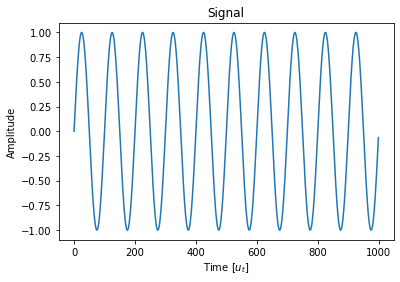

In [17]:
plt.plot(t,S)
plt.title('Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time [$u_t$]')

### Model noise: Extracting values from a Gaussian distribution
- the Gaussian distribution from which the values are extracted are defined from the [numpy.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)
- this fuction has one imput -- the mean (in this case 0, should remain like that for noise)
- additionally you might want to play with the keywords:
> - `scale` = standard devation (noise level)
> - `size` = size of the array (should be the same as the length of the signal `S`

In [18]:
# define noise with a standard deviation of a tenth of the amplitude of the sinusoidal function
noise = np.random.normal(0,scale = A/2, size = N)

In [19]:
# Add the noise to the original function 
Sn = S + noise

Text(0.5, 0, 'Time [$u_t$]')

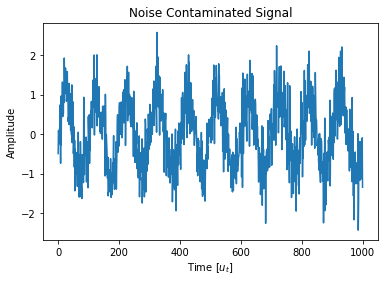

In [20]:
# plot the noise contaminated signal 
plt.plot(t,Sn)
plt.title('Noise Contaminated Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time [$u_t$]')

# This Notebook
- Up to this point the notebook has the same information as the original notebook. 
- In this notebook we will focus only on the reconnection rate `rdbrflx` and time `rdbt` variables. 
- We will explore the [np.fft](https://numpy.org/doc/stable/reference/routines.fft.html) module to perform the Fourier Transform on Data, the Fourier transform is formally

$\mathcal{F}(f)  = \int_{-\infty}^\infty f(t) e^{-2\pi i f t} dt$

- To compute the real Fourier Transform Coefficients we can use the [np.fft.rfft](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html) function
- We can evaluate the frequencies of these coefficients using the [np.fft.rfftfreq](https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html) function

NOTE: Remember that the Fourier Transform is a valid description of an oscillatory system. This will be relevant when working with real data.

## Calculate the Fourier Coefficients and Frequencies

In [21]:
dt = t[1]-t[0] # sampling time of the signal. 
Fcorf = np.fft.rfft(Sn) # The cofficients are complex
Fpowr = np.abs(Fcorf)**2 # We evaluate the complex conjugate which is reffered to as the Power Density
Ffreq = np.fft.rfftfreq(N,dt) # The frequencies of each given coefficient

## Plot the coeffiecients

Text(0.5, 0, 'Frequency [$u_t^{-1}$]')

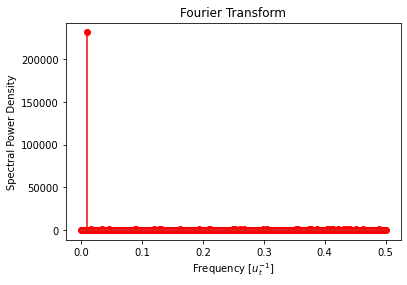

In [22]:
plt.stem(Ffreq,Fpowr,'r')
plt.title('Fourier Transform')
plt.ylabel('Spectral Power Density')
plt.xlabel('Frequency [$u_t^{-1}$]')

The frequency with the enhanced power density is the component which corresponds to the sine function. We can plot the power spectrum againts the period to extract the oscillation characteristic by visual inspection. 

<ipython-input-23-2d8bea58a411>:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.stem(1/Ffreq,Fpowr,'r')


Text(0.5, 0, 'Period [$u_t$]')

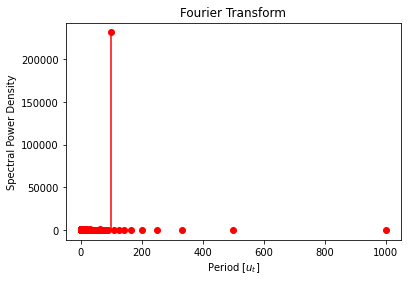

In [23]:
plt.stem(1/Ffreq,Fpowr,'r')
plt.title('Fourier Transform')
plt.ylabel('Spectral Power Density')
plt.xlabel('Period [$u_t$]')

## Windowing
- Consider a signal that is not periodic
- We need to force this signal to behave like a periodic function for the Fourier Transform to work properly

Text(0.5, 0, 'Time [$u_t$]')

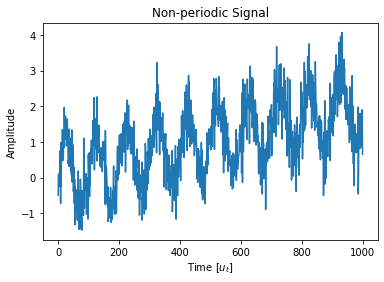

In [24]:
Sn2 = S + noise + t/500 # non-periodic sine function
# plot the noise contaminated signal of a non-periodic sine function'
plt.plot(t,Sn2)
plt.title('Non-periodic Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time [$u_t$]')

### Evaluate the Fourier Transform of the non-periodic signal

In [25]:
Fcorf2 = np.fft.rfft(Sn2) # The cofficients are complex
Fpowr2 = np.abs(Fcorf2)**2 # We evaluate the complex conjugate which is reffered to as the Power Density
Ffreq2 = np.fft.rfftfreq(N,dt) # The frequencies of each given coefficient

<ipython-input-26-ba29e1e580a1>:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.stem(1/Ffreq,Fpowr2,'r')


Text(0.5, 0, 'Period [$u_t$]')

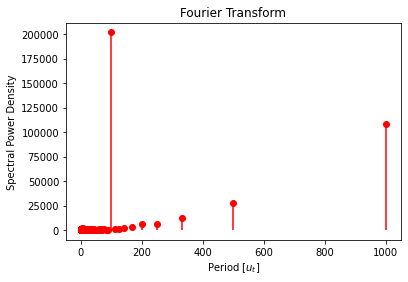

In [26]:
plt.stem(1/Ffreq,Fpowr2,'r')
plt.title('Fourier Transform')
plt.ylabel('Spectral Power Density')
plt.xlabel('Period [$u_t$]')

The power density is now spread out through non-oscillatory frequencies. The second largest peaks corresponds to the linear trend. By defining a compact normalized periodic function we can force any function to behave like its periodic.

Text(0.5, 0, 'Time [$u_t$]')

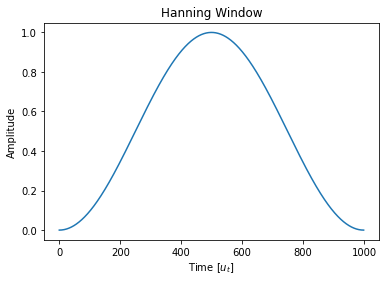

In [27]:
window = np.hanning(N) # One of the most common windowing functions is called the Hanning Window
# plot the window
plt.plot(t,window)
plt.title('Hanning Window')
plt.ylabel('Amplitude')
plt.xlabel('Time [$u_t$]')

By multiplying the original signal by the window, we force it to behave like a periodic function. 

Text(0.5, 0, 'Time [$u_t$]')

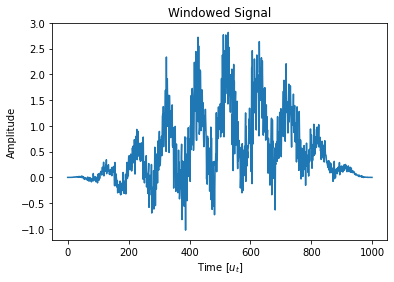

In [28]:
Sn3 = Sn2 * window
# plot the window
plt.plot(t,Sn3)
plt.title('Windowed Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time [$u_t$]')

Let's see the efects of this artificial forcing of periodicity. 

In [29]:
Fcorf3 = np.fft.rfft(Sn3) # The cofficients are complex
Fpowr3 = np.abs(Fcorf3)**2 # We evaluate the complex conjugate which is reffered to as the Power Density
Ffreq3 = np.fft.rfftfreq(N,dt) # The frequencies of each given coefficient

<ipython-input-30-3b90db51f3bd>:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.stem(1/Ffreq,Fpowr3,'r')


Text(0.5, 0, 'Period [$u_t$]')

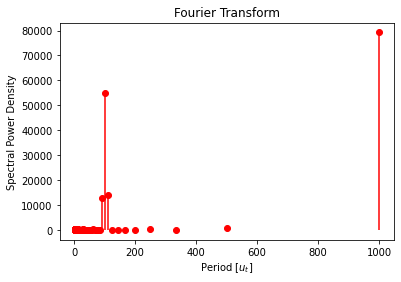

In [30]:
plt.stem(1/Ffreq,Fpowr3,'r')
plt.title('Fourier Transform')
plt.ylabel('Spectral Power Density')
plt.xlabel('Period [$u_t$]')

Now we see two seconday peaks by the enhancement of the sine function. This is called [spectral leakage](https://en.wikipedia.org/wiki/Spectral_leakage). It describes the local Fourier component power density spreading to the neighboring frequencies. 

Steps for Fourier Transform: 

1) Window Function to force periodicity  

2) Calculate the Fouerir Coefficients using the FFT 

3) Evaluate the frequencies for the calculated coefficients

4) Extract the frequencies with enhanced power

# Your Task
- Apply the FFT algorithm to the 4 signals you created in your previous notebook. 
- Identify the characteristic periods if the signals by visual inspection. 

# Our Work Together
- We will apply the FFT algorith to the reconnection rate signal